# Reto | Predicción de Contingencias Ambientales en el Área Metropolitana de la Ciudad de Monterrey 🌎

**Duración:** 2.5 h

**Introducción:**

Una contingencia ambiental se presenta cuando un contaminante de la atmósfera rebasa los límites establecidos por las normas de calidad del aire vigentes. En diversos países existen contingencias ambientales, el área metropolitana de la ciudad de Monterrey en México es muy frecuente.

Las condiciones del clima como presión, temperatura, humedad relativa, luz solar, velocidad y dirección del viento, etc. afectan la concentración de contaminantes.



Existe la propuesta de implementar un programa de verificación vehicular. Se pretende investigar si la contaminación está ligada al tráfico usando la hora del día cómo representante del mismo.



**Objetivo:**

Con el desarrollo del reto integrarás todos los conocimientos adquiridos, cumpliendo los siguientes objetivos:

* Descubrir relaciones entre las variables dependientes e independientes para crear modelos predictivos usando correlación.
* Aplicar modelos predictivos de machine learning y evalúa los resultados.

**Instrucciones:**
1. Realiza un análisis de correlación y establece qué variables ambientales o de tiempo afectan la concentración de contaminantes O3 y PM2.5.
2. Crea modelos de correlación para predecir estos contaminantes con la menor cantidad de variables atributo posible.
3. Evalúa los modelos.
4. Desarrolla tus conclusiones a partir de los resultados obtenidos.

**Indicaciones:**

El archivo de datos “Monterrey Pollution Data 2.csv” contiene las lecturas de una estación de monitoreo de calidad ambiental durante el año 2015 situada en el centro de la ciudad de Monterrey. Hay una lectura por hora. Cada renglón reporta las siguientes variables (Tabla 1):

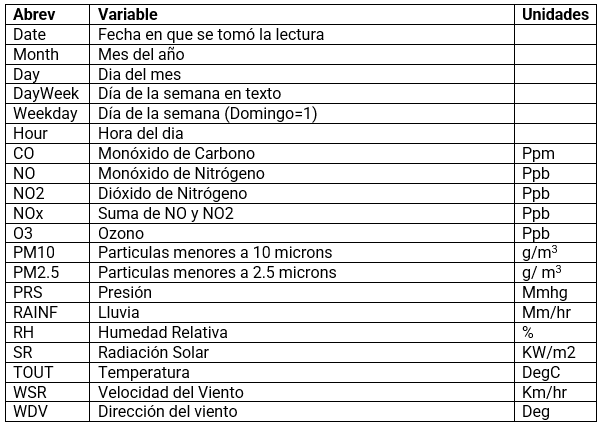

El gobierno del estado de Nuevo León está preocupado particularmente por las variables O3 que no debe exceder 120 ppb y por partículas que diámetro menor a 2.5 micrones (PM2.5) que no debe exceder 40.5 g/m3. El resto de los contaminantes son considerados precursores.

## 1.	Para concretar este proyecto realiza los siguientes pasos:

a)	En algún entorno Spark, carga los datos y elimina las variables innecesarias.

b)	Realiza un análisis de correlación y establece qué variables ambientales o de tiempo afectan la concentración de contaminantes O3 y PM2.5. Algunas correlaciones son negativas. Toma en cuenta que algunas correlaciones son positivas y algunas negativas indicando que los contaminantes incrementan y otras bajan.

c)	Confirma estas relaciones usando gráficos de dispersión.

d)	Crea modelos de regresión para predecir estos contaminantes con la menor cantidad de variables atributos posible. Puedes utilizar cualquier técnica: regresión lineal (o polinomial) multivariable, random forrests, gradient boost, o cualquier otra técnica que hayas investigado que funcione en Spark.

### Instalación de Spark y configuración básica

In [1]:
# Instalar Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# Descargar Spark desde un mirror específico (versión 3.0.3 con Hadoop 2.7)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz
# Descomprimir el archivo
!tar xf spark-3.0.3-bin-hadoop2.7.tgz
# Instalar findspark
!pip install -q findspark

In [2]:
# Configurar las variables de entorno
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"

# Inicializar findspark
import findspark
findspark.init()

In [3]:
# Importación de otras librerías
from google.colab import files
from pyspark import SparkContext, SparkConf,SQLContext
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np

In [4]:
# Creación de sparksession y sparkcontext
sc = SparkContext.getOrCreate(SparkConf().setMaster('local[*]'))
spark = SparkSession \
    .builder \
    .getOrCreate()
sqlContext = SQLContext(sc)

# Validación de versión de SparkContext
sc.version

'3.0.3'

### Lectura y limpieza de datos

In [76]:
path_pollution = '/content/drive/MyDrive/Colab Notebooks/ML_PySpark/PollutionData2.csv'

# Crear un Spark Dataframe con el contenido de un archivo
df_pollution = spark.read.csv(path_pollution, header=True, inferSchema=True)
df_pollution.show(10)

+---------+-----+---+-------+-------+----+----+----+----+----+---+----+-----+-----+-----+---+-----+----+---+---+
|     Date|Month|Day|DayWeek|WeekDay|Hour|  CO|  NO| NO2| NOX| O3|PM10|PM2.5|  PRS|RAINF| RH|   SR|TOUT|WSR|WDV|
+---------+-----+---+-------+-------+----+----+----+----+----+---+----+-----+-----+-----+---+-----+----+---+---+
|01-ene-15|    1|  1|    jue|      5|   1|2.51|10.2|12.9|23.1| 10| 139|   80|725.4| 0.01| 96|  0.0|3.91|7.2|344|
|01-ene-15|    1|  1|    jue|      5|   2|2.41| 9.2|11.6|20.8|  7|  42|   29|725.0| 0.02| 96|  0.0|3.81|6.3|341|
|01-ene-15|    1|  1|    jue|      5|   3|2.39| 8.1|11.8|19.9|  7|  23|    9|724.4|  0.0| 96|  0.0|3.85|5.2|346|
|01-ene-15|    1|  1|    jue|      5|   5|2.26| 5.3| 8.9|14.2|  7|  23|   14|724.0| 0.01| 96|  0.0|3.79|5.6|336|
|01-ene-15|    1|  1|    jue|      5|   8|2.25| 7.2|10.2|17.4|  5|  15|    8|724.3|  0.0| 96|0.023|3.93|4.8|354|
|01-ene-15|    1|  1|    jue|      5|   9|2.21| 5.8| 8.2|14.0|  7|  16|    6|724.3|  0.0| 96|0.0

In [77]:
# Observar estructura de los datos
df_pollution.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- DayWeek: string (nullable = true)
 |-- WeekDay: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- CO: double (nullable = true)
 |-- NO: double (nullable = true)
 |-- NO2: double (nullable = true)
 |-- NOX: double (nullable = true)
 |-- O3: integer (nullable = true)
 |-- PM10: integer (nullable = true)
 |-- PM2.5: integer (nullable = true)
 |-- PRS: double (nullable = true)
 |-- RAINF: double (nullable = true)
 |-- RH: integer (nullable = true)
 |-- SR: double (nullable = true)
 |-- TOUT: double (nullable = true)
 |-- WSR: double (nullable = true)
 |-- WDV: integer (nullable = true)



In [78]:
df_pollution.columns

['Date',
 'Month',
 'Day',
 'DayWeek',
 'WeekDay',
 'Hour',
 'CO',
 'NO',
 'NO2',
 'NOX',
 'O3',
 'PM10',
 'PM2.5',
 'PRS',
 'RAINF',
 'RH',
 'SR',
 'TOUT',
 'WSR',
 'WDV']

In [79]:
# Eliminar variables innecesarias de fechas y PM10 que es precursora y no directamente relacionada con tráfico vehicular
df_poll = df_pollution
columns_to_drop = ['Date', 'DayWeek', 'PM10']
df_poll = df_poll.drop(*columns_to_drop)
df_poll = df_poll.withColumnRenamed("PM2.5", "PM2_5")
df_poll.show(10)

+-----+---+-------+----+----+----+----+----+---+-----+-----+-----+---+-----+----+---+---+
|Month|Day|WeekDay|Hour|  CO|  NO| NO2| NOX| O3|PM2_5|  PRS|RAINF| RH|   SR|TOUT|WSR|WDV|
+-----+---+-------+----+----+----+----+----+---+-----+-----+-----+---+-----+----+---+---+
|    1|  1|      5|   1|2.51|10.2|12.9|23.1| 10|   80|725.4| 0.01| 96|  0.0|3.91|7.2|344|
|    1|  1|      5|   2|2.41| 9.2|11.6|20.8|  7|   29|725.0| 0.02| 96|  0.0|3.81|6.3|341|
|    1|  1|      5|   3|2.39| 8.1|11.8|19.9|  7|    9|724.4|  0.0| 96|  0.0|3.85|5.2|346|
|    1|  1|      5|   5|2.26| 5.3| 8.9|14.2|  7|   14|724.0| 0.01| 96|  0.0|3.79|5.6|336|
|    1|  1|      5|   8|2.25| 7.2|10.2|17.4|  5|    8|724.3|  0.0| 96|0.023|3.93|4.8|354|
|    1|  1|      5|   9|2.21| 5.8| 8.2|14.0|  7|    6|724.3|  0.0| 96|0.052|4.13|4.2| 15|
|    1|  1|      5|  12|2.38|10.0|10.1|20.1| 10|   17|722.6|  0.0| 96|0.127| 6.6|3.2| 29|
|    1|  1|      5|  13|2.51|11.5|12.3|23.8| 12|   16|721.7|  0.0| 95| 0.15|6.89|4.8|  2|
|    1|  1

### Análisis de correlación para establecer qué variables ambientales o de tiempo afectan la concentración de contaminantes O3 y PM2.5

In [80]:
# Estadísticos de las variables
df_poll.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Month,3859,4.820678932365898,2.8352877939176295,1,11
Day,3859,15.76444674786214,9.157213402989008,1,31
WeekDay,3859,4.075926405804613,1.9730397456778965,1,7
Hour,3859,12.037833635656906,6.869487540512553,0,23
CO,3859,1.8006219227779212,0.8720340991225567,0.29,8.56
NO,3859,13.503653796320318,26.856244699079294,2.3,414.3
NO2,3859,17.539284788381988,13.301006799154928,0.4,99.2
NOX,3859,30.973257321216455,36.090498039388464,3.1,436.0
O3,3859,22.658719875615443,16.51056131885926,2,92


In [81]:
# Cuantiles
quantiles = df_poll.approxQuantile(df_poll.columns, [0.25, 0.5, 0.75], 0)
quantiles_df = pd.DataFrame(data=quantiles, index=df_poll.columns,columns=[0.25, 0.5, 0.75])
quantiles_df

,0.25,0.50,0.75
Month,2.00,4.000,7.000
Day,8.00,16.000,24.000
WeekDay,2.00,4.000,6.000
Hour,6.00,13.000,18.000
CO,1.13,1.760,2.220
NO,4.00,6.100,10.400
NO2,7.70,13.500,23.200
NOX,11.90,20.200,34.600
O3,10.00,18.000,32.000
PM2_5,15.00,25.000,36.000


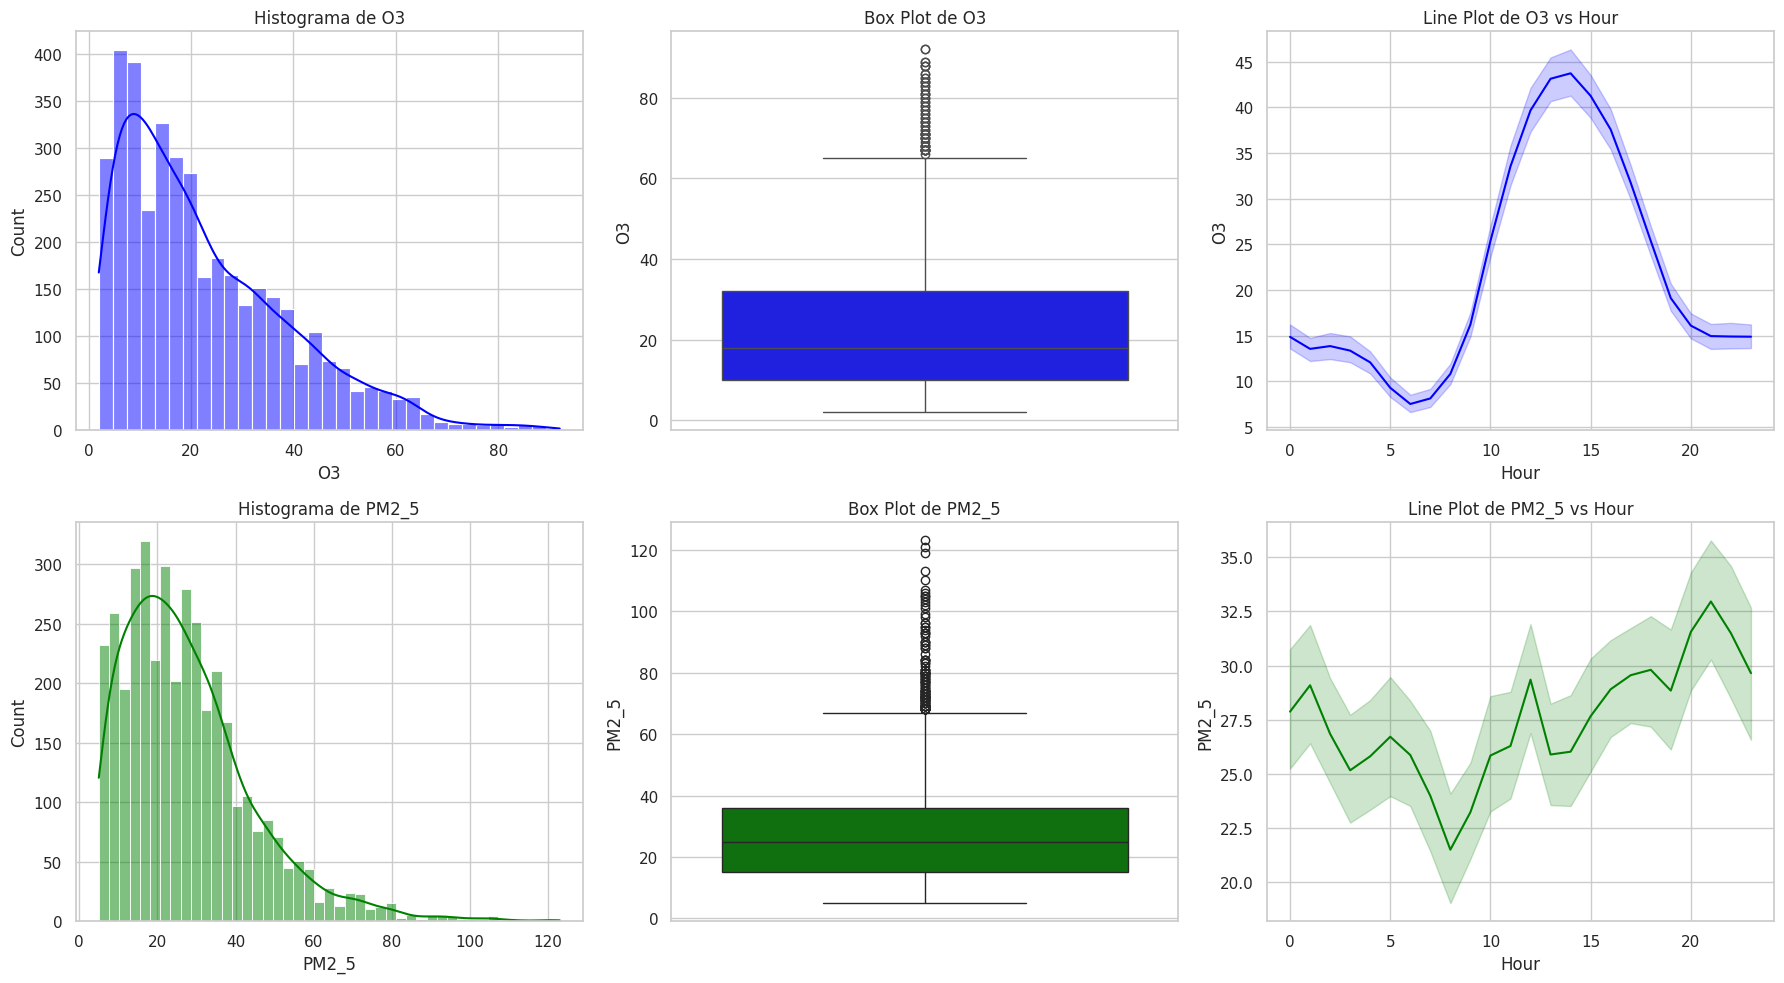

In [35]:
# Visualizar variables de interés
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo
sns.set(style="whitegrid")

# Crear la figura y los ejes para la visualización 2x3
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Histograma de O3
sns.histplot(df_poll.toPandas(), x="O3", kde=True, ax=axes[0, 0], color="blue")
axes[0, 0].set_title("Histograma de O3")

# Histograma de PM2_5
sns.histplot(df_poll.toPandas(), x="PM2_5", kde=True, ax=axes[1, 0], color="green")
axes[1, 0].set_title("Histograma de PM2_5")

# Box plot de O3
sns.boxplot(data=df_poll.toPandas(), y="O3", ax=axes[0, 1], color="blue")
axes[0, 1].set_title("Box Plot de O3")

# Box plot de PM2_5
sns.boxplot(data=df_poll.toPandas(), y="PM2_5", ax=axes[1, 1], color="green")
axes[1, 1].set_title("Box Plot de PM2_5")

# Line plot de O3 vs Hour
sns.lineplot(data=df_poll.toPandas(), x="Hour", y="O3", ax=axes[0, 2], color="blue")
axes[0, 2].set_title("Line Plot de O3 vs Hour")

# Line plot de PM2_5 vs Hour
sns.lineplot(data=df_poll.toPandas(), x="Hour", y="PM2_5", ax=axes[1, 2], color="green")
axes[1, 2].set_title("Line Plot de PM2_5 vs Hour")

# Ajustar espacios
plt.tight_layout()
plt.show()

In [82]:
# Obtención de correlaciones
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# Ensamblar vector
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_poll.columns, outputCol=vector_col)
df_vector = assembler.transform(df_poll).select(vector_col)

r1 = Correlation.corr(df_vector, vector_col)
correlation_matrix = r1.collect()[0]["pearson({})".format(vector_col)].values
print("Pearson Corr Matrix\n",correlation_matrix)

Pearson Corr Matrix
 [ 1.         -0.06681874  0.00577055  0.0054055  -0.54861099 -0.31319863
 -0.59194504 -0.45351715  0.21388996 -0.05753043 -0.43358683 -0.0108237
 -0.18114563  0.1609054   0.67349906  0.26464103 -0.22102167 -0.06681874
  1.         -0.00598214 -0.00155594  0.10161249  0.03817932  0.05592515
  0.04917678  0.0894571  -0.0136505  -0.03661393 -0.02347321 -0.2098234
  0.06236327  0.11085136  0.04526884  0.0283507   0.00577055 -0.00598214
  1.         -0.00860741  0.03326163 -0.03619181 -0.02281854 -0.03533288
  0.01599319  0.01675521  0.06762479  0.03130008  0.0775407  -0.0104502
 -0.06985465  0.0251707  -0.04951724  0.0054055  -0.00155594 -0.00860741
  1.          0.06385422 -0.06897343  0.06570135 -0.02702815  0.2283809
  0.09788411 -0.04785694  0.0207946  -0.36251786  0.04857046  0.21874229
  0.42407231 -0.12821527 -0.54861099  0.10161249  0.03326163  0.06385422
  1.          0.5978396   0.67806613  0.69620186 -0.19644118  0.21761599
  0.2516326   0.01022539  0.104442

In [85]:
# Convertir la matriz de correlación a un DataFrame de pandas
num_cols = len(df_poll.columns)  # Número de columnas originales
df_corr = pd.DataFrame(
    correlation_matrix.reshape(num_cols, num_cols),
    columns=df_poll.columns,
    index=df_poll.columns
)

df_corr

,Month,Day,WeekDay,Hour,CO,NO,NO2,NOX,O3,PM2_5,PRS,RAINF,RH,SR,TOUT,WSR,WDV
Month,1.000000,-0.066819,0.005771,0.005405,-0.548611,-0.313199,-0.591945,-0.453517,0.213890,-0.057530,-0.433587,-0.010824,-0.181146,0.160905,0.673499,0.264641,-0.221022
Day,-0.066819,1.000000,-0.005982,-0.001556,0.101612,0.038179,0.055925,0.049177,0.089457,-0.013651,-0.036614,-0.023473,-0.209823,0.062363,0.110851,0.045269,0.028351
WeekDay,0.005771,-0.005982,1.000000,-0.008607,0.033262,-0.036192,-0.022819,-0.035333,0.015993,0.016755,0.067625,0.031300,0.077541,-0.010450,-0.069855,0.025171,-0.049517
Hour,0.005405,-0.001556,-0.008607,1.000000,0.063854,-0.068973,0.065701,-0.027028,0.228381,0.097884,-0.047857,0.020795,-0.362518,0.048570,0.218742,0.424072,-0.128215
CO,-0.548611,0.101612,0.033262,0.063854,1.000000,0.597840,0.678066,0.696202,-0.196441,0.217616,0.251633,0.010225,0.104443,-0.166540,-0.417004,-0.341591,0.232311
NO,-0.313199,0.038179,-0.036192,-0.068973,0.597840,1.000000,0.562418,0.952031,-0.275251,0.232708,0.175222,-0.009182,0.068039,-0.103299,-0.291055,-0.343986,0.259888
NO2,-0.591945,0.055925,-0.022819,0.065701,0.678066,0.562418,1.000000,0.788449,-0.302997,0.302022,0.285011,0.009580,0.009099,-0.200736,-0.443810,-0.488231,0.261746
NOX,-0.453517,0.049177,-0.035333,-0.027028,0.696202,0.952031,0.788449,1.000000,-0.316941,0.284654,0.236130,-0.003227,0.054647,-0.151194,-0.381639,-0.436568,0.290354
O3,0.213890,0.089457,0.015993,0.228381,-0.196441,-0.275251,-0.302997,-0.316941,1.000000,-0.008811,-0.219732,-0.030142,-0.655588,0.691927,0.527154,0.466254,-0.198798
PM2_5,-0.057530,-0.013651,0.016755,0.097884,0.217616,0.232708,0.302022,0.284654,-0.008811,1.000000,-0.178029,0.030746,0.036154,-0.037306,0.083703,-0.071178,-0.032373


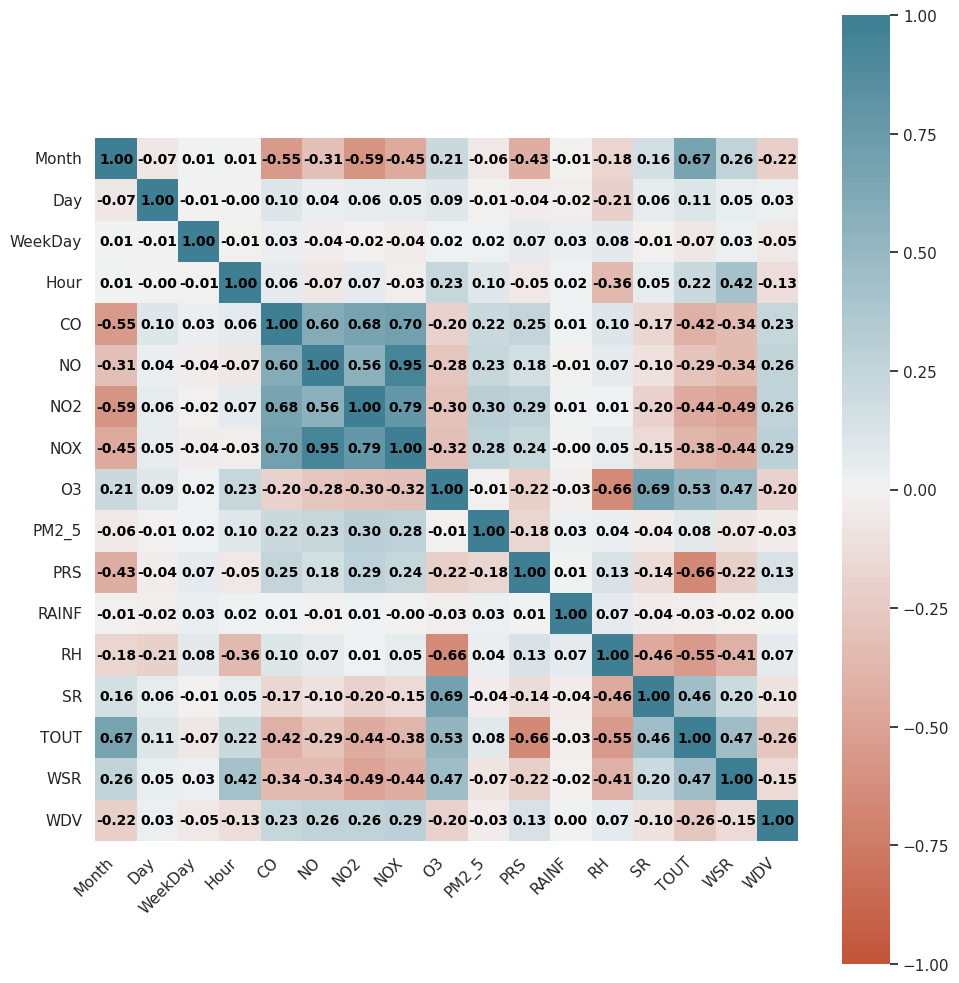

In [84]:
# Mapa de calor para visualizar correlaciones
import seaborn as sns
sns.set(color_codes=True, font_scale=1.0)
from matplotlib import pyplot as plt
#Establecer el tamaño de la figura
plt.figure(figsize=(10,10))
ax = sns.heatmap(
    df_corr,
    annot=True,
    fmt=".2f",
    vmin=-1, vmax=1,
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot_kws={"size": 10, "weight": "bold", "color": "black"}
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

# Mostrar la visualización
plt.tight_layout()
plt.show()

In [86]:
# Crear df_O3 con índice y variable O3, ordenado por valores absolutos
df_O3 = df_corr[['O3']].copy()
df_O3['abs_O3'] = df_O3['O3'].abs()
df_O3 = df_O3.sort_values(by='abs_O3', ascending=False)
df_O3.drop(columns=['abs_O3'], inplace=True)

# Crear df_PM2_5 con índice y variable PM2_5, ordenado por valores absolutos
df_PM2_5 = df_corr[['PM2_5']].copy()
df_PM2_5['abs_PM2_5'] = df_PM2_5['PM2_5'].abs()
df_PM2_5 = df_PM2_5.sort_values(by='abs_PM2_5', ascending=False)
df_PM2_5.drop(columns=['abs_PM2_5'], inplace=True)

# DataFrames resultantes
print("df_O3:")
print(df_O3)

print("\ndf_PM2_5:")
print(df_PM2_5)

df_O3:
               O3
O3       1.000000
SR       0.691927
RH      -0.655588
TOUT     0.527154
WSR      0.466254
NOX     -0.316941
NO2     -0.302997
NO      -0.275251
Hour     0.228381
PRS     -0.219732
Month    0.213890
WDV     -0.198798
CO      -0.196441
Day      0.089457
RAINF   -0.030142
WeekDay  0.015993
PM2_5   -0.008811

df_PM2_5:
            PM2_5
PM2_5    1.000000
NO2      0.302022
NOX      0.284654
NO       0.232708
CO       0.217616
PRS     -0.178029
Hour     0.097884
TOUT     0.083703
WSR     -0.071178
Month   -0.057530
SR      -0.037306
RH       0.036154
WDV     -0.032373
RAINF    0.030746
WeekDay  0.016755
Day     -0.013651
O3      -0.008811


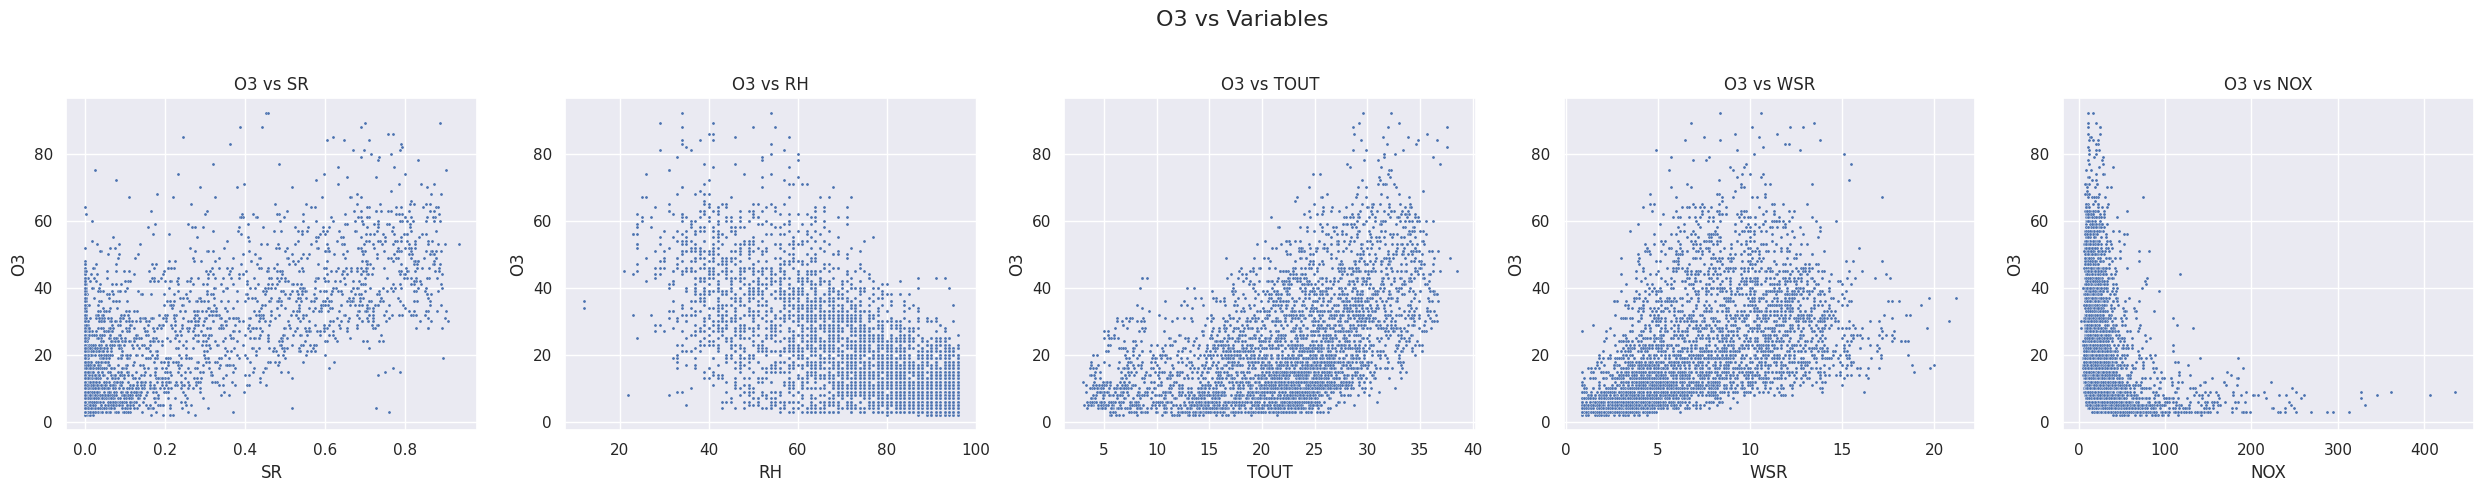

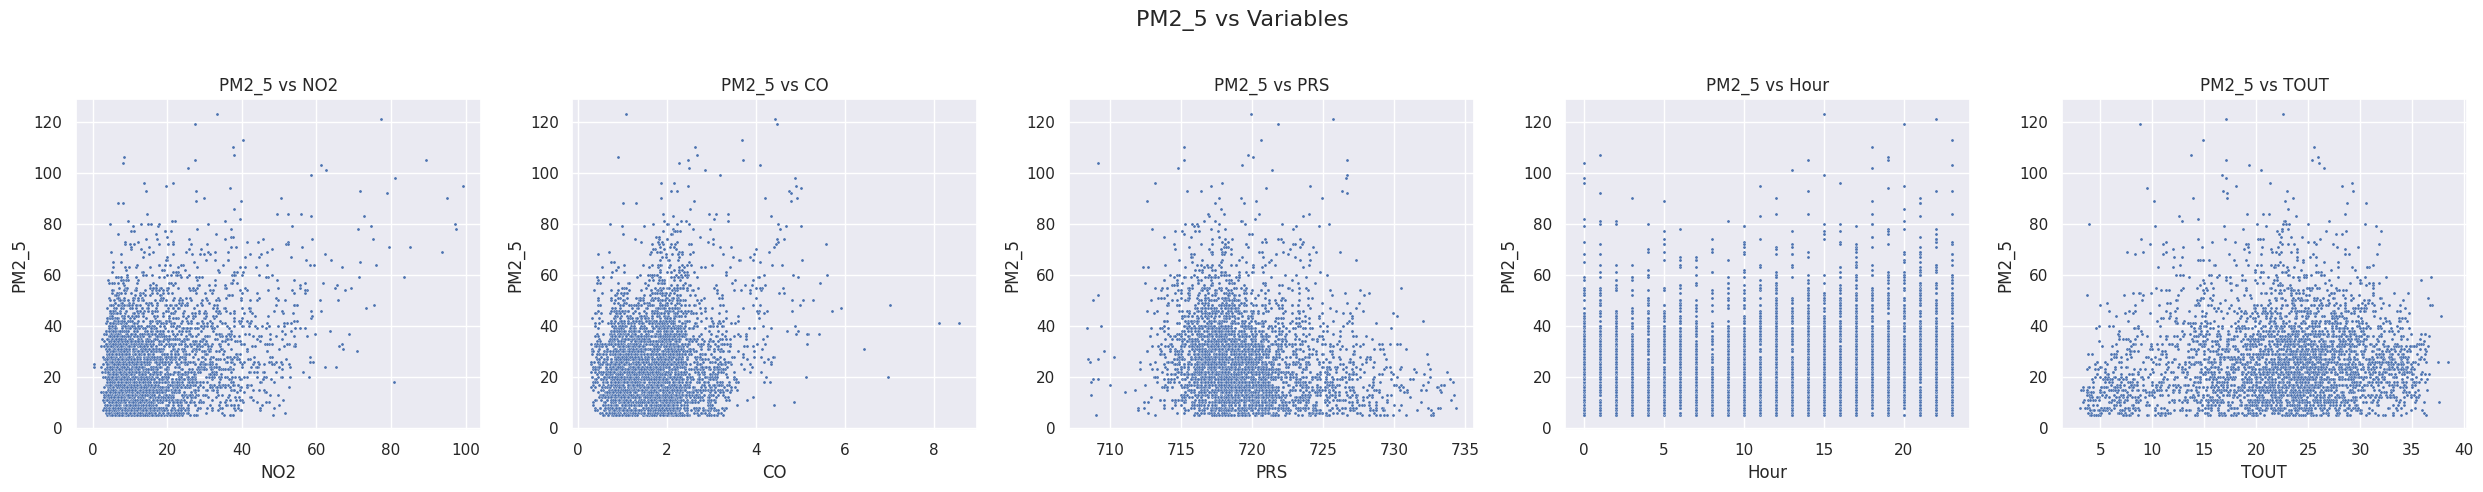

In [88]:
# Visualización de gráficos de dispersión
import matplotlib.pyplot as plt
import seaborn as sns

# Convertir el DataFrame de PySpark a pandas
df_poll_pandas = df_poll.toPandas()

# Variables para O3 y PM2_5
variables_O3 = ['SR', 'RH', 'TOUT', 'WSR', 'NOX']
variables_PM2_5 = ['NO2', 'CO', 'PRS', 'Hour', 'TOUT']

# Crear gráficos de dispersión para O3 vs otras variables
fig, axs = plt.subplots(1, 5, figsize=(25,5))
fig.suptitle('O3 vs Variables', fontsize=16)

for i, var in enumerate(variables_O3):
    sns.scatterplot(data=df_poll_pandas, x=var, y='O3', ax=axs[i], s=5)
    axs[i].set_title(f'O3 vs {var}')
    axs[i].set_xlabel(var)
    axs[i].set_ylabel('O3')

# Ajustar el espacio entre los subgráficos
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Crear gráficos de dispersión para PM2_5 vs otras variables
fig, axs = plt.subplots(1, 5, figsize=(25,5))
fig.suptitle('PM2_5 vs Variables', fontsize=16)

for i, var in enumerate(variables_PM2_5):
    sns.scatterplot(data=df_poll_pandas, x=var, y='PM2_5', ax=axs[i], s=5)
    axs[i].set_title(f'PM2_5 vs {var}')
    axs[i].set_xlabel(var)
    axs[i].set_ylabel('PM2_5')

# Ajustar el espacio entre los subgráficos
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Conclusiones de hallazgos en el análisis de correlaciones

A partir del análisis estadístico y los gráficos de dispersión, se identificaron varias relaciones clave entre las variables.

* **Colinealidad de la temperatura:**
La temperatura muestra una colinealidad significativa con el mes y la presión atmosférica, lo cual es esperado. Las estaciones del año afectan la temperatura y, a su vez, modifican la dinámica atmosférica, lo que influye en la presión. Esto tiene un impacto en la dispersión y concentración de contaminantes, como el Ozono (O3) y las partículas PM2.5.

* **Colinealidad de los contaminantes**:
Los contaminantes NOX, NO y NO2 por su naturaleza molecular muestran una colinealidad alta entre ellos. Será importante no incluir varios del grupo en un sólo modelo. Para los visuales de dispersión, solamente se incluyó el de mayor correlación.

* **Relaciones con el Ozono (O3):**
El Ozono presenta correlaciones moderadas a altas con la radiación solar (positiva), la humedad relativa (negativa), la temperatura (positiva) y la velocidad del viento (positiva). La radiación solar es fundamental en la formación de Ozono, mientras que niveles altos de humedad dificultan su concentración. La temperatura favorece su formación, y la velocidad del viento influye en su dispersión.

* **Relaciones con las partículas PM2.5:**
Las partículas PM2.5 muestran correlaciones moderadas positivas con los contaminantes NO2, NOX, NO y CO como es de esperarse, seguido de una relación negativa con la presión atmosférica que sugiere que las bajas presiones pueden facilitar la dispersión de partículas. También se observa correlación débil positiva con la hora del día y la temperatura, lo que indica que las concentraciones de PM2.5 aumentan durante las horas de mayor actividad humana y temperaturas más altas.


Estos hallazgos proporcionan una comprensión de los factores que afectan la calidad del aire, lo que puede ser útil para el diseño de estrategias de mitigación, especialmente en áreas urbanas y en zonas con altas emisiones de contaminantes como lo es la ciudad de Monterrey.

### Creación de modelos de regresión para predecir contaminantes


In [71]:
# Importación de librerías
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import classification_report, confusion_matrix

In [89]:
# Agregar columnas de clasificación para las variables de interés (donde 1 se define como un nivel no deseable del contaminante)
from pyspark.sql.functions import col, when

# Crear las columnas O3_class y PM2_5_class
df_poll = df_poll.withColumn(
    'O3_class', when(col('O3') >= 50, 1).otherwise(0)
).withColumn(
    'PM2_5_class', when(col('PM2_5') >= 30, 1).otherwise(0)
)

# Verificar que las columnas se crearon correctamente
df_poll.select('O3', 'PM2_5', 'O3_class', 'PM2_5_class').show(10)

+---+-----+--------+-----------+
| O3|PM2_5|O3_class|PM2_5_class|
+---+-----+--------+-----------+
| 10|   80|       0|          1|
|  7|   29|       0|          0|
|  7|    9|       0|          0|
|  7|   14|       0|          0|
|  5|    8|       0|          0|
|  7|    6|       0|          0|
| 10|   17|       0|          0|
| 12|   16|       0|          0|
| 14|   19|       0|          0|
| 11|   35|       0|          1|
+---+-----+--------+-----------+
only showing top 10 rows



#### Modelos de Regresión - variable O3

In [68]:
# Ensamblar las características en un solo vector
assembler = VectorAssembler(inputCols=['SR','RH','TOUT','WSR'], outputCol='features')
output = assembler.transform(df_poll)
finalized_data = output.select('features', 'O3')

# Dividir los datos en entrenamiento y prueba
train_data, test_data = finalized_data.randomSplit([0.8, 0.2], seed=1234)

# Definir los evaluadores
evaluator_r2 = RegressionEvaluator(labelCol='O3', predictionCol='prediction', metricName='r2')
evaluator_mse = RegressionEvaluator(labelCol='O3', predictionCol='prediction', metricName='mse')
evaluator_rmse = RegressionEvaluator(labelCol='O3', predictionCol='prediction', metricName='rmse')
evaluator_mae = RegressionEvaluator(labelCol='O3', predictionCol='prediction', metricName='mae')

# Modelos
models = {
    'Linear Regression': LinearRegression(featuresCol='features', labelCol='O3'),
    'Random Forest': RandomForestRegressor(featuresCol='features', labelCol='O3'),
    'GBT Regression': GBTRegressor(featuresCol='features', labelCol='O3')
}

# Iterar sobre los modelos
for model_name, model in models.items():
    # Entrenar el modelo
    model_trained = model.fit(train_data)

    # Hacer predicciones
    predictions = model_trained.transform(test_data)

    # Evaluar el modelo
    r2 = evaluator_r2.evaluate(predictions)
    mse = evaluator_mse.evaluate(predictions)
    rmse = evaluator_rmse.evaluate(predictions)
    mae = evaluator_mae.evaluate(predictions)

    # Imprimir los resultados
    print(f'{model_name} - R²: {r2:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}')

Linear Regression - R²: 0.6688, MSE: 97.3267, RMSE: 9.8654, MAE: 7.2293
Random Forest - R²: 0.7037, MSE: 87.0780, RMSE: 9.3316, MAE: 6.8562
GBT Regression - R²: 0.7269, MSE: 80.2728, RMSE: 8.9595, MAE: 6.4946


#### Modelos de Clasificación - variable O3

In [74]:
# Ensamblar las características en un solo vector
assembler = VectorAssembler(inputCols=['SR','RH','TOUT','WSR'], outputCol='features')
output = assembler.transform(df_poll)
finalized_data = output.select('features', 'O3_class')

# Dividir los datos en entrenamiento y prueba
train_data, test_data = finalized_data.randomSplit([0.8, 0.2], seed=1234)

# Definir los evaluadores
evaluator = MulticlassClassificationEvaluator(labelCol='O3_class', predictionCol='prediction')

# Modelos de clasificación
models = {
    'Logistic Regression': LogisticRegression(featuresCol='features', labelCol='O3_class'),
    'Random Forest': RandomForestClassifier(featuresCol='features', labelCol='O3_class'),
    'GBT Classifier': GBTClassifier(featuresCol='features', labelCol='O3_class')
}

# Iterar sobre los modelos
for model_name, model in models.items():
    # Entrenar el modelo
    model_trained = model.fit(train_data)

    # Hacer predicciones
    predictions = model_trained.transform(test_data)

    # Evaluar el modelo con F1
    f1_score = evaluator.evaluate(predictions, {evaluator.metricName: 'f1'})
    print(f"{model_name} - Test F1: {f1_score:.4f}")

    # Obtener muestra de predicciones para la matriz de confusión
    predictions_sampled = predictions.sample(0.8)

    # Obtener valores reales y predicciones
    y_true = predictions_sampled.select(['O3_class']).collect()
    y_pred = predictions_sampled.select(['prediction']).collect()

    # Imprimir clasificación y matriz de confusión
    print(classification_report([row['O3_class'] for row in y_true], [row['prediction'] for row in y_pred]))
    print(confusion_matrix([row['O3_class'] for row in y_true], [row['prediction'] for row in y_pred]))

Logistic Regression - Test F1: 0.9188
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       548
           1       0.54      0.37      0.44        54

    accuracy                           0.92       602
   macro avg       0.74      0.67      0.70       602
weighted avg       0.90      0.92      0.91       602

[[531  17]
 [ 34  20]]
Random Forest - Test F1: 0.9218
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       533
           1       0.62      0.46      0.53        54

    accuracy                           0.93       587
   macro avg       0.79      0.72      0.75       587
weighted avg       0.92      0.93      0.92       587

[[518  15]
 [ 29  25]]
GBT Classifier - Test F1: 0.9251
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       550
           1       0.56      0.49      0.52        49

    accuracy                     

#### Modelos de Regresión - variable PM2.5

In [90]:
# Ensamblar las características en un solo vector
assembler = VectorAssembler(inputCols=['NO2','CO','PRS','Hour'], outputCol='features') # se excluyen contaminantes con colinealidad alta
output = assembler.transform(df_poll)
finalized_data = output.select('features', 'PM2_5')

# Dividir los datos en entrenamiento y prueba
train_data, test_data = finalized_data.randomSplit([0.8, 0.2], seed=1234)

# Definir los evaluadores
evaluator_r2 = RegressionEvaluator(labelCol='PM2_5', predictionCol='prediction', metricName='r2')
evaluator_mse = RegressionEvaluator(labelCol='PM2_5', predictionCol='prediction', metricName='mse')
evaluator_rmse = RegressionEvaluator(labelCol='PM2_5', predictionCol='prediction', metricName='rmse')
evaluator_mae = RegressionEvaluator(labelCol='PM2_5', predictionCol='prediction', metricName='mae')

# Modelos
models = {
    'Linear Regression': LinearRegression(featuresCol='features', labelCol='PM2_5'),
    'Random Forest': RandomForestRegressor(featuresCol='features', labelCol='PM2_5'),
    'GBT Regression': GBTRegressor(featuresCol='features', labelCol='PM2_5')
}

# Iterar sobre los modelos
for model_name, model in models.items():
    # Entrenar el modelo
    model_trained = model.fit(train_data)

    # Hacer predicciones
    predictions = model_trained.transform(test_data)

    # Evaluar el modelo
    r2 = evaluator_r2.evaluate(predictions)
    mse = evaluator_mse.evaluate(predictions)
    rmse = evaluator_rmse.evaluate(predictions)
    mae = evaluator_mae.evaluate(predictions)

    # Imprimir los resultados
    print(f'{model_name} - R²: {r2:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}')

Linear Regression - R²: 0.1567, MSE: 247.4847, RMSE: 15.7316, MAE: 12.0641
Random Forest - R²: 0.1892, MSE: 237.9478, RMSE: 15.4256, MAE: 11.7888
GBT Regression - R²: 0.1113, MSE: 260.8086, RMSE: 16.1496, MAE: 12.0621


#### Modelos de Clasificación - variable PM2.5

In [91]:
# Ensamblar las características en un solo vector
assembler = VectorAssembler(inputCols=['NO2','CO','PRS','Hour'], outputCol='features') # se excluyen contaminantes con colinealidad alta
output = assembler.transform(df_poll)
finalized_data = output.select('features', 'PM2_5_class')

# Dividir los datos en entrenamiento y prueba
train_data, test_data = finalized_data.randomSplit([0.8, 0.2], seed=1234)

# Definir los evaluadores
evaluator = MulticlassClassificationEvaluator(labelCol='PM2_5_class', predictionCol='prediction')

# Modelos de clasificación
models = {
    'Logistic Regression': LogisticRegression(featuresCol='features', labelCol='PM2_5_class'),
    'Random Forest': RandomForestClassifier(featuresCol='features', labelCol='PM2_5_class'),
    'GBT Classifier': GBTClassifier(featuresCol='features', labelCol='PM2_5_class')
}

# Iterar sobre los modelos
for model_name, model in models.items():
    # Entrenar el modelo
    model_trained = model.fit(train_data)

    # Hacer predicciones
    predictions = model_trained.transform(test_data)

    # Evaluar el modelo con F1
    f1_score = evaluator.evaluate(predictions, {evaluator.metricName: 'f1'})
    print(f"{model_name} - Test F1: {f1_score:.4f}")

    # Obtener muestra de predicciones para la matriz de confusión
    predictions_sampled = predictions.sample(0.8)

    # Obtener valores reales y predicciones
    y_true = predictions_sampled.select(['PM2_5_class']).collect()
    y_pred = predictions_sampled.select(['prediction']).collect()

    # Imprimir clasificación y matriz de confusión
    print(classification_report([row['PM2_5_class'] for row in y_true], [row['prediction'] for row in y_pred]))
    print(confusion_matrix([row['PM2_5_class'] for row in y_true], [row['prediction'] for row in y_pred]))

Logistic Regression - Test F1: 0.4970


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.64      1.00      0.78       376
           1       0.00      0.00      0.00       212

    accuracy                           0.64       588
   macro avg       0.32      0.50      0.39       588
weighted avg       0.41      0.64      0.50       588

[[376   0]
 [212   0]]
Random Forest - Test F1: 0.6416
              precision    recall  f1-score   support

           0       0.68      0.80      0.74       367
           1       0.51      0.36      0.42       213

    accuracy                           0.64       580
   macro avg       0.60      0.58      0.58       580
weighted avg       0.62      0.64      0.62       580

[[294  73]
 [137  76]]
GBT Classifier - Test F1: 0.6478
              precision    recall  f1-score   support

           0       0.69      0.79      0.74       367
           1       0.53      0.39      0.45       219

    accuracy                           0.64       586
   macro avg     

## 2. Evalúa los modelos y escribe la reflexión de tu evaluación.

### Modelos de Regresión para O3:

GBT Regression es el modelo más robusto para predecir el contaminante O3, con el mejor R² (0.7269), menor MSE (80.2728), RMSE (8.9595) y MAE (6.4946). Este modelo tiene un buen balance entre precisión y capacidad para generalizar a nuevos datos.
El Random Forest sigue de cerca en desempeño, pero tiene valores ligeramente más altos de MSE, RMSE y MAE, lo que sugiere que es un modelo menos preciso en comparación con GBT. Linear Regression tiene el peor desempeño con un R² de 0.6688, lo que indica una capacidad de predicción más limitada en comparación con los otros dos modelos.

### Modelos de Clasificación para O3:

GBT Classifier es el modelo más preciso para predecir la clasificación de O3, con el mejor F1 (0.9251). El recall de la clase 1 no es perfecto, pero sigue siendo el mejor modelo en este aspecto. Es importante considerar que los modelos tienen margen de mejora, especialmente en cuanto a la predicción de altas concentraciones (clase 1) que son las de interés.

### Modelos de Regresión para PM2.5:

Los tres modelos de regresión para PM2.5 (Linear Regression, Random Forest y GBT Regression) presentan un desempeño muy pobre. Los valores de R² son extremadamente bajos (alrededor de 0.11-0.19), lo que sugiere que ninguno de los modelos tiene una buena capacidad de predicción. En términos de MSE, RMSE y MAE, los tres modelos también presentan valores elevados, indicando que las predicciones son imprecisas.

### Modelos de Clasificación para PM2.5:

GBT Classifier es el modelo que muestra el mejor F1 (0.6478), aunque todavía bajo, indicando que el modelo tiene un desempeño moderado. Tiene un desempeño equilibrado entre precisión (0.53) y recall (0.39) para la clase 1 (altas concentraciones), aunque aún presenta limitaciones significativas.

### Evaluación final con base en los hallazgos:
Para O3, el GBT Regression y el GBT Classifier son los modelos más recomendables, debido al balance adecuado entre precisión, recall y otras métricas importantes. Estos modelos son particularmente efectivos para predecir tanto las concentraciones bajas como altas de O3.

Para PM2.5, los modelos de regresión no parecen ser efectivos para la predicción continua de este contaminante debido a la baja capacidad de explicación de la variabilidad en los datos. En cuanto a clasificación, el GBT Classifier es el modelo más eficaz para predecir las altas concentraciones (clase 1), aunque el rendimiento sigue siendo limitado debido al desbalance entre las clases.

## 3. Conclusiones, contesta lo siguiente y justifica tus respuesta:

### a)	¿Puedes decir que la contaminación por O3 o PM2.5 está ligada al tráfico vehicular?

La contaminación por O3 y PM2.5 está influenciada por múltiples variables, y en este análisis se encontraron patrones interesantes. Para el caso del ozono (O3), las concentraciones altas están más relacionadas con variables ambientales como la radiación solar, la humedad relativa, la temperatura y el viento. Estas variables sugieren que el O3 tiene un vínculo más fuerte con condiciones meteorológicas que favorecen su formación, como la radiación solar que intensifica las reacciones fotoquímicas.

En contraste, para las partículas PM2.5, se observó una relación más directa con contaminantes relacionados con fuentes antropogénicas como el NO2, NOx, NO y CO, además de la presión atmosférica y, en menor medida, la hora del día. Estos contaminantes están estrechamente vinculados al tráfico vehicular, lo que sugiere que este factor tiene un papel más relevante en las concentraciones de PM2.5.

Sin embargo, para establecer una relación más sólida entre el tráfico vehicular y la contaminación por estos compuestos, sería necesario incorporar datos adicionales como la cantidad de vehículos en circulación, la proximidad a vías principales y un análisis detallado de las temporalidades. Estos datos permitirían fortalecer el vínculo entre las emisiones vehiculares y la calidad del aire, especialmente en el caso de las partículas PM2.5.

### b)	¿Consideras que tendría efectos sobre la contaminación implantar un esquema de verificación vehicular?

Sí, implementar un esquema de verificación vehicular tendría efectos positivos en la reducción de la contaminación. Esto contribuiría a que los vehículos que circulan cumplan con estándares de emisión más estrictos, lo que reduciría la cantidad de contaminantes liberados al ambiente.

En este análisis, se observó una correlación significativa entre las concentraciones de contaminantes como NO2, NOx, NO y CO (que pueden ser de fuentes vehiculares), y partículas PM2.5, lo que refuerza la importancia de limitar las emisiones generadas.

### c)	Con un reporte del pronóstico del clima dado en la mañana, ¿puedes predecir que habrá una contingencia ambiental debido a que los contaminantes en el aire rebasaron los límites permitidos por la norma? ¿Por qué razón (es)?

Para los contaminantes como el O3, sería posible realizar una predicción relativamente probable basándonos en el pronóstico del clima, ya que variables como la radiación solar, la temperatura y el viento están significativamente relacionadas con sus concentraciones.

En el caso de los contaminantes PM2.5, aunque también presentan cierta relación con variables meteorológicas, la predicción resulta más compleja, ya que intervienen otros factores importantes, como las concentraciones de NO2, NOx, NO y CO. Por lo tanto, para predecir contingencias ambientales de manera más precisa, sería necesario incluir estas variables adicionales y trabajar en el fortalecimiento del modelo predictivo.

### d)	En tus propias palabras, ¿cuáles consideras qué son las condiciones climáticas se deben cumplir para tener altos niveles de contaminación de O3? ¿Y PM2.5?

Para O3:
*	Alta radiación solar, ya que la formación de ozono es un proceso impulsado por la luz solar.
*	Baja humedad relativa, que facilita la acumulación al reducir los mecanismos de remoción húmeda.
*	Alta temperatura, que acelera las reacciones químicas necesarias para su formación.
*	Altas velocidades del viento, que pueden transportar precursores, incrementando las concentraciones en zonas específicas.

Para PM 2.5:
*	Baja presión atmosférica, que dificulta la dispersión de partículas.
*	Alta temperatura, que favorece la formación secundaria de partículas.
*	Poca velocidad del viento, que limita la capacidad de dispersión de las partículas.